In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage import color
import skimage.measure
import cv2
from IPython.display import SVG

import face_recognition

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import tensorflow as tf
from keras import layers
import keras
from keras.utils import plot_model
from keras import backend as K

import random
import math
import os

import string
import time
import re
import nltk
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
tf.get_logger().setLevel('ERROR')

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## NLP stuff

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/errorgorn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    #print(tag_dict.get(tag, wordnet.NOUN))
    return tag_dict.get(tag, wordnet.NOUN)

pattern = re.compile("【|】|\[|\]")

# Initalize TweetTokenizer
tt = TweetTokenizer()

# English stop words
english_stops = stopwords.words('english')

printable = set(string.printable)

# Instantiate the WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def editString(title):
    title = pattern.sub("|",title)                             # replace square brackets with |
    title = "".join(filter(lambda x: x in printable, title))   # remove non printable characters
    #print(title)
    tokens = tt.tokenize(text=title)
    
    # Convert the tokens into lowercase: lower_tokens, indicate if capital
    tokens_edited = [t.lower() + " [&CAP] " if (t.upper() == t and t.isalpha() and len(t) > 1) else t.lower() for t in tokens ]
    #print(tokens_edited)
    # Remove all stop words: no_stops
    no_stops = [t for t in tokens_edited if t not in english_stops]
    #print(no_stops)
    # Lemmatize all tokens into a new list: lemmatized
    lemmatized = [wordnet_lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in no_stops]
    #print(lemmatized)
    return " ".join(lemmatized)



## Get df stuff

In [8]:
def get_img(id):
    return mpimg.imread('thumbs/'+id+'.jpg')

In [9]:
def get_face(id,num):
    if (os.path.isfile('faces/'+id+'_'+str(num)+'.jpg')): return mpimg.imread('faces/'+id+'_'+str(num)+'.jpg')
    else: return np.ones((96,96,3),dtype='uint8')*128

In [10]:
def get_df(file):
    df=pd.read_csv(file,index_col=0)
    df=df.T
    df=df.reset_index(drop=True)
    
    #nlp
    df["title"]=df["title"].apply(editString)
    df["clickbait"]=df["clickbait"].astype(int)
    
    return df

In [11]:
df=get_df('scraping youtube/metadata.csv')
df2=get_df('human acc/metadata.csv')
df3=get_df('scraping youtube/metadata_b0.csv')

In [12]:
print(df2[df2["id"]=="SlPhMPnQ58k"])
print(df3[df3["id"]=="kJQP7kiw5Fk"])
print(df3[df3["id"]=="R_oVq2hCy70"])

                                    title              views            likes  \
35   maroon 5 - memory ( official video )  705,162,545 views  7,624,617 likes   
129  maroon 5 - memory ( official video )  705,163,401 views  7,624,619 likes   

             dislikes                                               desc  \
35   170,752 dislikes  “Memories” is out now:\nhttps://smarturl.it/Me...   
129  170,752 dislikes  “Memories” is out now:\nhttps://smarturl.it/Me...   

              id  clickbait  
35   SlPhMPnQ58k          0  
129  SlPhMPnQ58k          0  
                                        title                views  \
62   luis fonsi - despacito ft . daddy yankee  7,293,692,975 views   
137  luis fonsi - despacito ft . daddy yankee  7,293,692,975 views   

                likes            dislikes  \
62   43,569,832 likes  4,990,350 dislikes   
137  43,569,842 likes  4,990,351 dislikes   

                                                  desc           id  clickbait  
62   “Des

XXXXXXX SERIOUS ERROR XXXXXXXX

In [13]:
df2=df2.drop([35,129])
df3=df3.drop([128,137])

In [14]:
df_m=pd.concat([df,df2,df3])
df_m=df_m.set_index("id")
df_m

title  \
id                                                               
K15jFOVrAy4  veteran ' voice 2020 : general joseph votel , ...   
lG3PEdw0xrU                              make tandoori chicken   
0vUgGSLTtOg       25 airbag rainbow explosion 4k - slow mo guy   
d17H1uhfYjw  hunt secret [&CAP]  megalodon [&CAP]  boss [&C...   
KTF1Nqvl8ug             maroon 5 - wanna know ( behind scene )   
...                                                        ...   
NddZ5ftQb0Q  cheeseburger hydrochloric acid - periodic tabl...   
gDmcL3LBEo4                                    real edge glory   
fRh_vgS2dFE  justin bieber - sorry ( purpose [&CAP]  : move...   
BVXvkQcHD9o  100 chicken [&CAP]  nuggets [&CAP]  in [&CAP] ...   
v_0HNAneqWY  slide [&CAP]  * new [&CAP]  * rare [&CAP]  for...   

                           views             likes            dislikes  \
id                                                                       
K15jFOVrAy4         22,540 views          92 likes         28 dislikes   
lG3PEdw0xrU      1,724,176 views      93,482 likes      7,647 dislikes   
0vUgGSLTtOg      6,431,213 views     185,758 likes      1,712 dislikes   
d17H1uhfYjw        457,053 views      12,111 likes        386 dislikes   
KTF1Nqvl8ug      1,050,911 views      27,807 likes        287 dislikes   
...                          ...               ...                 ...   
NddZ5ftQb0Q     19,789,646 views      23,927 likes      2,179 dislikes   
gDmcL3LBEo4      9,689,348 views     219,715 likes      1,970 dislikes   
fRh_vgS2dFE  3,420,744,514 views  14,089,589 likes  1,660,385 dislikes   
BVXvkQcHD9o     12,843,075 views     269,026 likes      4,407 dislikes   
v_0HNAneqWY      1,572,841 views     123,187 likes      1,225 dislikes   

                                                          desc  clickbait  
id                                                                         
K15jFOVrAy4  Veterans served their nation selflessly, but s...          0  
lG3PEdw0xrU  Today I show you how to make authentic Tandoor...          1  
0vUgGSLTtOg  Sometimes ideas get too big for our backyard s...          0  
d17H1uhfYjw  If you enjoyed this video, watch more here: ht...          1  
KTF1Nqvl8ug  Buy “Don't Wanna Know" ft. Kendrick LaMar now....          0  
...                                                        ...        ...  
NddZ5ftQb0Q  You can support us on Patreon: https://www.pat...          0  
gDmcL3LBEo4         This is the greatest sharpener of All Time          1  
fRh_vgS2dFE  ‘Purpose’ Available Everywhere Now!\niTunes: h...          0  
BVXvkQcHD9o  Today we attempt the 100 chicken nugget challe...          0  
v_0HNAneqWY  We slide for our RARE loot in Fortnite!\n\n🔔 S...          1  

[10075 rows x 6 columns]

In [15]:
s,s2,s3=df["id"],df2["id"],df3["id"]

## NLP 2

In [16]:
def load_dataset_from_df(df):
    #print(df)
    target = df['clickbait']
    values = df['title']
    dataset = tf.data.Dataset.from_tensor_slices((values, target))
    return dataset

In [17]:
titles=df["title"]

In [18]:
titles

0       veteran ' voice 2020 : general joseph votel , ...
1                                   make tandoori chicken
2            25 airbag rainbow explosion 4k - slow mo guy
3       hunt secret [&CAP]  megalodon [&CAP]  boss [&C...
4                  maroon 5 - wanna know ( behind scene )
                              ...                        
9734    maroon 5 - pepsi super bowl liii [&CAP]  halft...
9735    * new [&CAP]  * fortnite [&CAP]  nuke [&CAP]  ...
9736     spraying [&CAP]  skunk [&CAP]  prank [&CAP]  ! !
9737    reacting [&CAP]  to [&CAP]  the [&CAP]  old [&...
9738                                  birthday faze house
Name: title, Length: 9739, dtype: object

In [19]:
# Model constants.
max_features = 10000
embedding_dim = 32
sequence_length = 300

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    standardize = None,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Now that the vocab layer has been created, call `adapt` on a text-only
# dataset to create the vocabulary. You don't have to batch, but for very large
# datasets this means you're not keeping spare copies of the dataset in memory.

# Let's call `adapt`:
vectorize_layer.adapt(titles.to_numpy())

In [20]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

In [21]:
vectorize_text("loli")

<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Screwing around with images

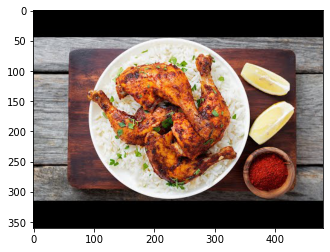

In [22]:
plt.imshow(get_img(df["id"][1])) #nice chicken

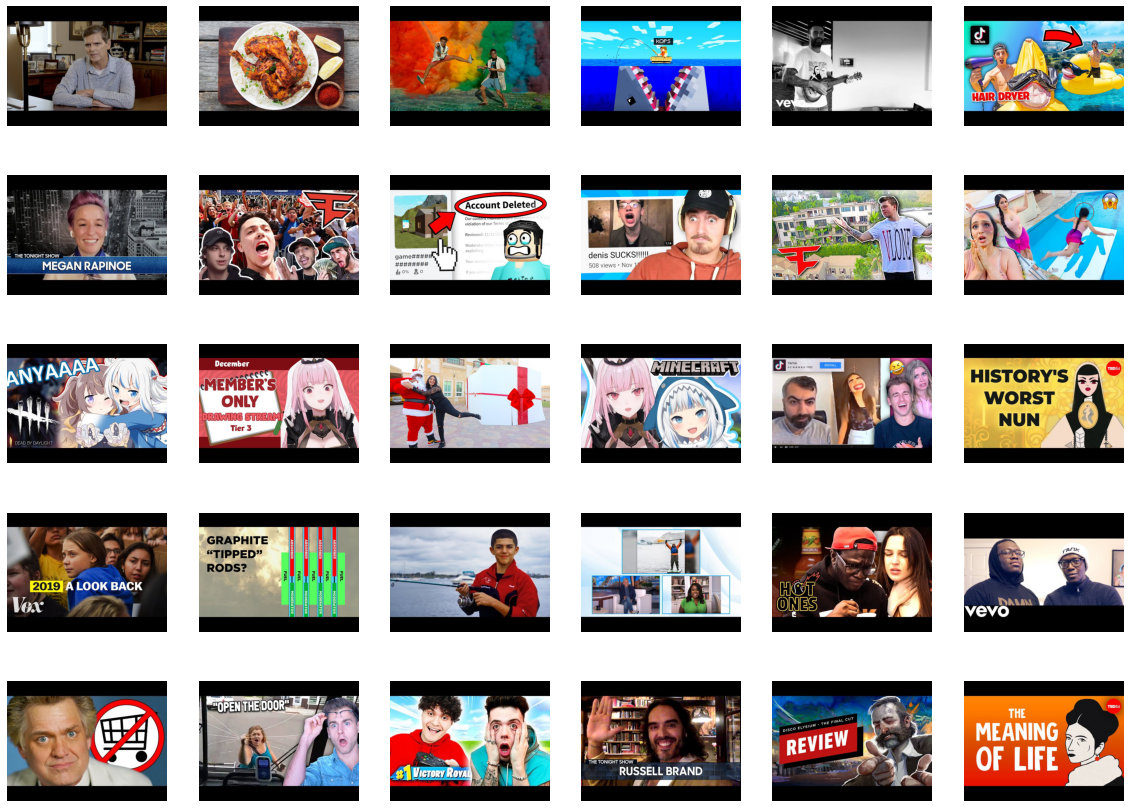

In [23]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        axs[i,j].imshow(get_img(df["id"][i*6+j]))

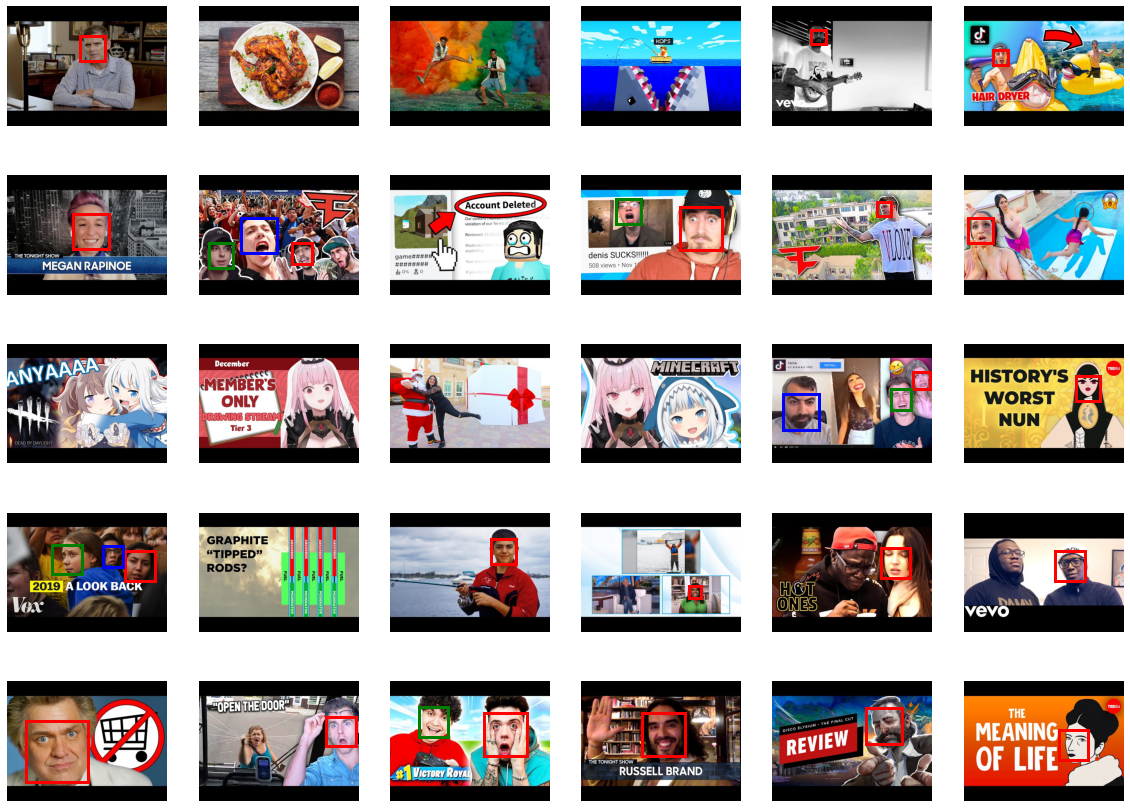

In [24]:
fig,axs=plt.subplots(5,6,figsize=(20,15))

for x in axs.ravel():
    x.axis('off')

for i in range(5):
    for j in range(6):
        img=get_img(df["id"][i*6+j])
        axs[i,j].imshow(img)
        
        locs=face_recognition.face_locations(img)
        
        for x in range(min(3,len(locs))):
            t,r,b,l=locs[x]
            
            rect=patches.Rectangle((l,t),r-l,b-t,linewidth=3,edgecolor="rgb"[x],facecolor='none')
            axs[i,j].add_patch(rect)

## autoencoders

In [42]:
def encoder(t,b,l,r):
    tf.keras.backend.clear_session() #prevent high mem usage
    
    n,m=b-t,r-l
    
    # read faces from files
    
    #blank image here (since we will have to process blank images later)
    faces=[np.ones(shape=(n*m,))*0.5]
    
    for file in os.listdir("faces"):
        face=mpimg.imread('faces/'+file)[:,:,0]
        face=cv2.resize(face,(96,96))
        face=face[t:b,l:r].reshape(-1)
        face=(face-face.mean())/(face.std()*3)+0.5
        faces.append(face.reshape(-1)) #flatten
    
    faces=np.array(faces)
        
    #build autoencoder
    #it is actually just a single dense layer
    
    input_encoder=layers.Input((n*m,))
    
    #encoder
    encoded=layers.Dense(16,activation='sigmoid')(input_encoder) #latent space of 4

    encoder=keras.Model(
        inputs=[input_encoder],
        outputs=[encoded],
    )
    
    #decoder
    decoded=layers.Dense(n*m,activation='sigmoid')(encoded)

    train=keras.Model(
        inputs=[input_encoder],
        outputs=[decoded],
    )
    
    #train the autoencoder
    train.compile(
      optimizer="adam",
      loss="mean_squared_error",
    )
    
    #do 100 epochs
    train.fit(faces,faces,validation_split=0.2,epochs=20,batch_size=8,steps_per_epoch=1000)
    
    #display some examples of autoencoder
    fig,axs=plt.subplots(6,17,figsize=(17,6))
    
    for x in axs.ravel():
        x.axis('off')

    pred=train.predict(faces[:17])
    pred2=encoder.predict(faces[:17])

    for i in range(17):
        axs[0,i].imshow(faces[i].reshape(n,m)) #in
        axs[2,i].imshow(pred[i].reshape(n,m)) #out
        axs[1,i].imshow(pred2[i].reshape(4,4)) #latent space
        
    #get decoder
    train.get_weights()
    
    inp=layers.Input(16)
    dense=layers.Dense(n*m)(inp)
    
    decoder=keras.Model(
        inputs=[inp],
        outputs=[dense],
    )
    decoder.set_weights(train.get_weights()[2:])
    
    temp=np.zeros(shape=(17,16))
    for i in range(16): temp[i+1][i]=1
    
    #show each parameter of the latent layer
    pred=decoder.predict(temp)
    
    for i in range(17):
        axs[5,i].imshow(pred[i].reshape(n,m)) #out
        axs[4,i].imshow(temp[i].reshape(4,4)) #latent space
    
    #return encoder and converter for use later
    return encoder,train

Epoch 1/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0906 - val_loss: 0.0672
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0582
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0565 - val_loss: 0.0535
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 0.0505
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0495 - val_loss: 0.0481
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0475 - val_loss: 0.0461
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0456 - val_loss: 0.0451
Epoch 8/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0442 - val_loss: 0.0437
Epoch 9/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0430 - val_loss: 0.0431
Epoch 10/20
1000/1000 [==============================] - 1s 1ms/step - loss: 0.042

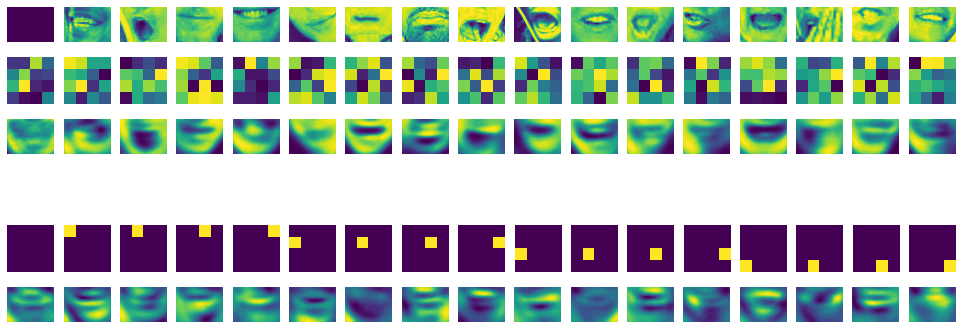

In [43]:
encode_mouth,conv_mouth=encoder(60,96,24,72)

## model

In [44]:
def get_io(s):
    thumb=[]
    titles=[]
    faces=[]
    ans=[]

    for id in s:
        img=get_img(id)[44:314]
        thumb.append(img)
        
        vec=vectorize_text(df_m["title"][id])
        titles.append(vec)
        
        face=get_face(id,0)
        face=cv2.resize(face,(96,96))
        faces.append(face)
        
        ans.append(df_m["clickbait"][id])
        
    X={
        "thumb":np.array(thumb),
        "title":np.array(titles).reshape(-1,300),
        "face":np.array(faces)
    }
    
    y=np.array(ans).reshape(-1,1).astype(int)
    
    return X,y

In [45]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [46]:
X_train,y_train=get_io(s)
X_test,y_test=get_io(s2)

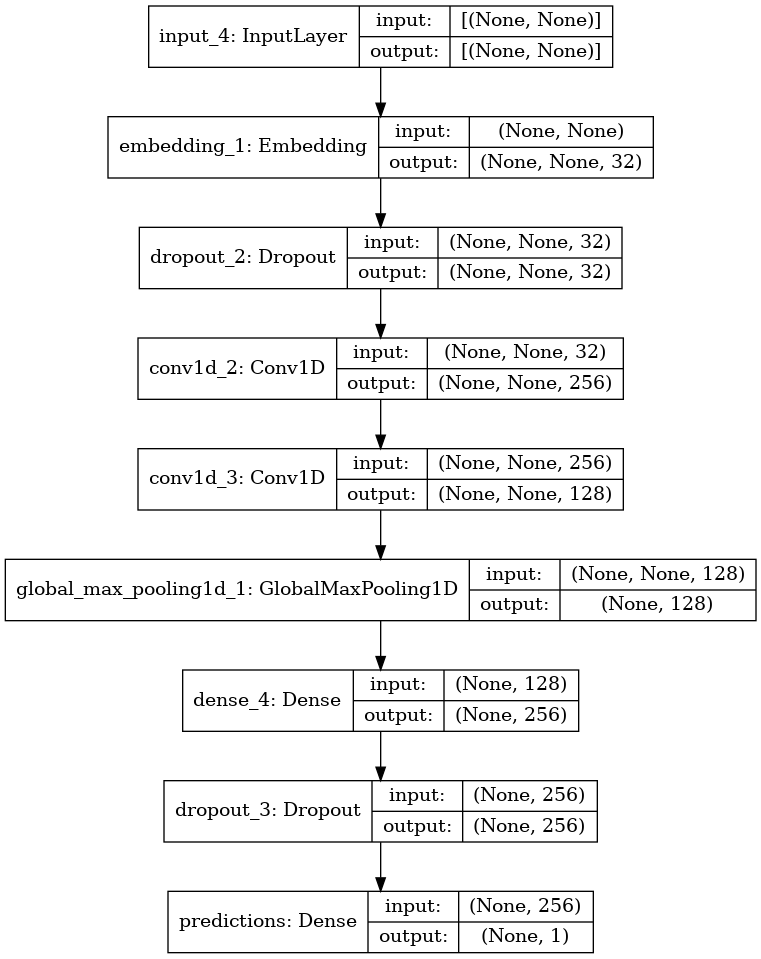

In [51]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [52]:
epochs = 5
model.fit(X_train["title"],y_train, validation_split=0.2, epochs=epochs)

Epoch 1/5
244/244 [==============================] - 2s 7ms/step - loss: 0.5967 - acc: 0.6227 - precision_m: 0.3387 - recall_m: 0.2263 - f1_m: 0.2406 - val_loss: 0.2565 - val_acc: 0.8840 - val_precision_m: 0.8507 - val_recall_m: 0.9014 - val_f1_m: 0.8703
Epoch 2/5
244/244 [==============================] - 2s 6ms/step - loss: 0.2277 - acc: 0.9043 - precision_m: 0.9005 - recall_m: 0.8809 - f1_m: 0.8869 - val_loss: 0.2044 - val_acc: 0.9158 - val_precision_m: 0.9267 - val_recall_m: 0.8827 - val_f1_m: 0.9010
Epoch 3/5
244/244 [==============================] - 2s 6ms/step - loss: 0.1546 - acc: 0.9367 - precision_m: 0.9391 - recall_m: 0.9161 - f1_m: 0.9243 - val_loss: 0.2000 - val_acc: 0.9158 - val_precision_m: 0.8933 - val_recall_m: 0.9231 - val_f1_m: 0.9046
Epoch 4/5
244/244 [==============================] - 2s 7ms/step - loss: 0.1271 - acc: 0.9498 - precision_m: 0.9515 - recall_m: 0.9309 - f1_m: 0.9386 - val_loss: 0.2091 - val_acc: 0.9174 - val_precision_m: 0.8959 - val_recall_m: 0.9262

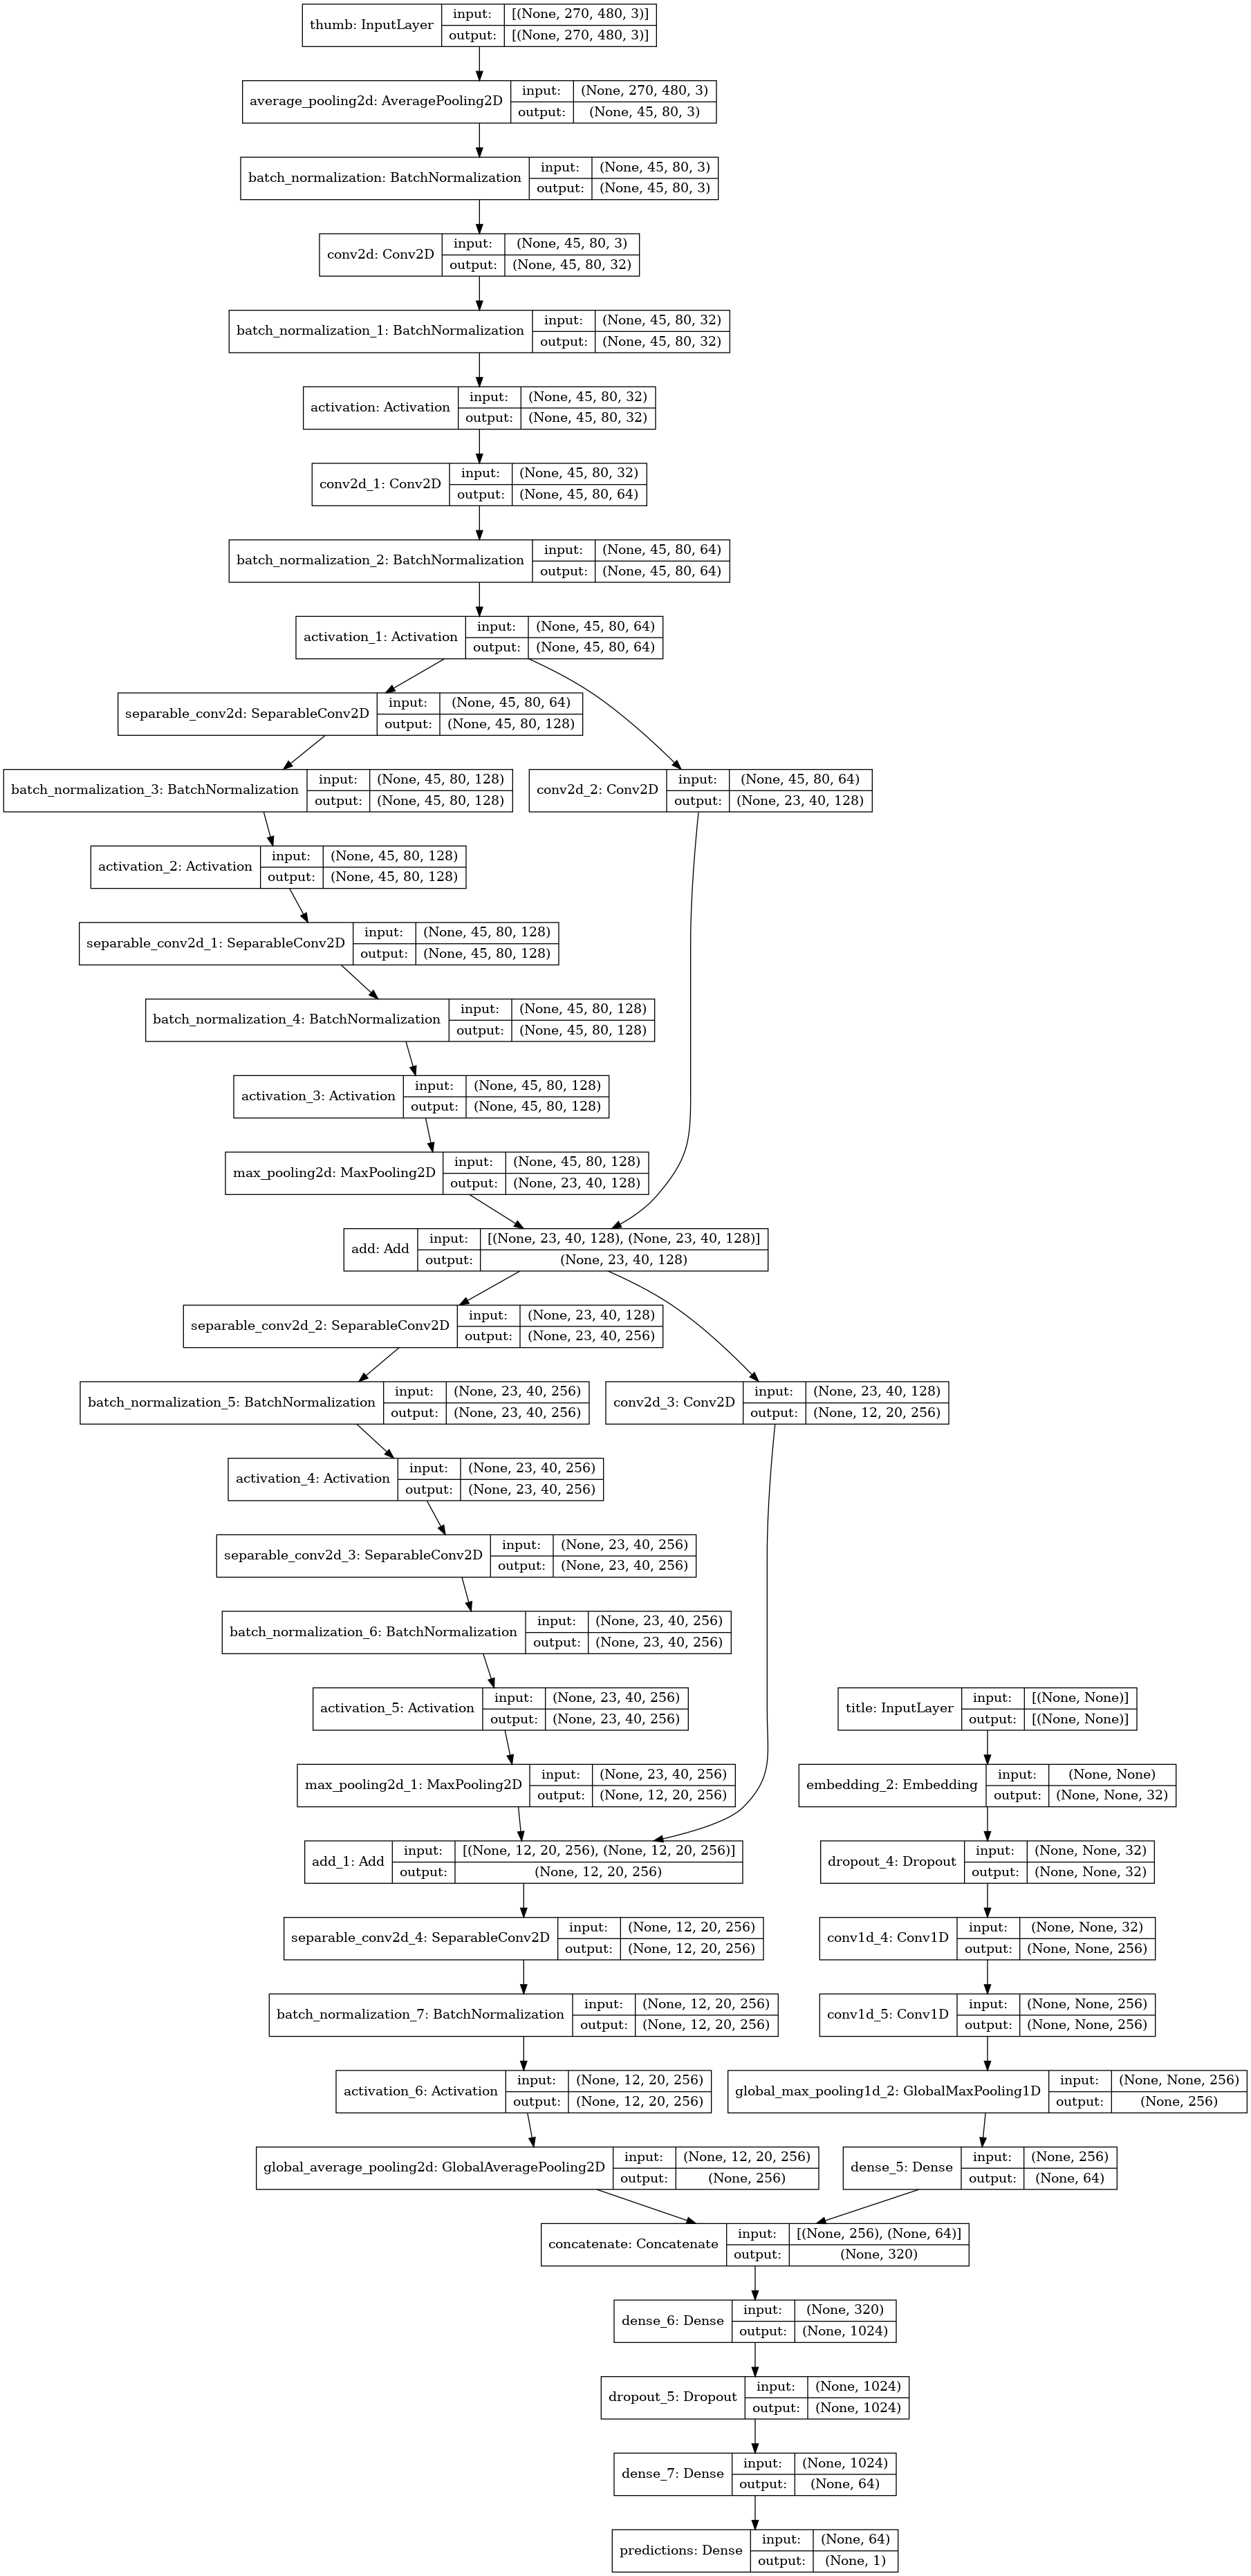

In [53]:
thumbnail_input=keras.Input(shape=(270,480,3),name='thumb')

#2d conv for thumbnail
x=layers.AveragePooling2D(6)(thumbnail_input)
x=layers.BatchNormalization()(x)

x=layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

prev=x

for size in [128, 256]:
    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size,1,strides=2,padding="same")(prev)
    
    x = layers.add([x,residual])  # Add back residual
    prev=x                        # Set aside next residual


x=layers.SeparableConv2D(256,3,padding="same")(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

flat=layers.GlobalAveragePooling2D()(x)

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64",name="title")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
flat2 = layers.GlobalMaxPooling1D()(x)

dense=layers.Dense(64,activation='relu')(flat2)

# We add a vanilla hidden layer:
flat_comb=layers.concatenate([flat,dense])
x = layers.Dense(1024, activation="relu")(flat_comb)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
x = layers.Dense(64,activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model([thumbnail_input,inputs], predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [54]:
epochs = 5
model.fit(X_train,y_train, validation_split=0.2, epochs=epochs)

Epoch 1/5


/home/errorgorn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['face'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


244/244 [==============================] - 25s 100ms/step - loss: 0.5558 - acc: 0.6858 - precision_m: 0.6712 - recall_m: 0.5919 - f1_m: 0.5874 - val_loss: 0.2407 - val_acc: 0.8978 - val_precision_m: 0.9495 - val_recall_m: 0.8186 - val_f1_m: 0.8746
Epoch 2/5
244/244 [==============================] - 25s 101ms/step - loss: 0.1803 - acc: 0.9266 - precision_m: 0.9237 - recall_m: 0.9069 - f1_m: 0.9116 - val_loss: 0.1850 - val_acc: 0.9261 - val_precision_m: 0.9262 - val_recall_m: 0.9086 - val_f1_m: 0.9141
Epoch 3/5
244/244 [==============================] - 23s 96ms/step - loss: 0.1293 - acc: 0.9470 - precision_m: 0.9418 - recall_m: 0.9367 - f1_m: 0.9374 - val_loss: 0.2584 - val_acc: 0.8984 - val_precision_m: 0.8247 - val_recall_m: 0.9762 - val_f1_m: 0.8903
Epoch 4/5
244/244 [==============================] - 23s 96ms/step - loss: 0.0924 - acc: 0.9650 - precision_m: 0.9614 - recall_m: 0.9577 - f1_m: 0.9576 - val_loss: 0.2925 - val_acc: 0.9035 - val_precision_m: 0.9823 - val_recall_m: 0.8014

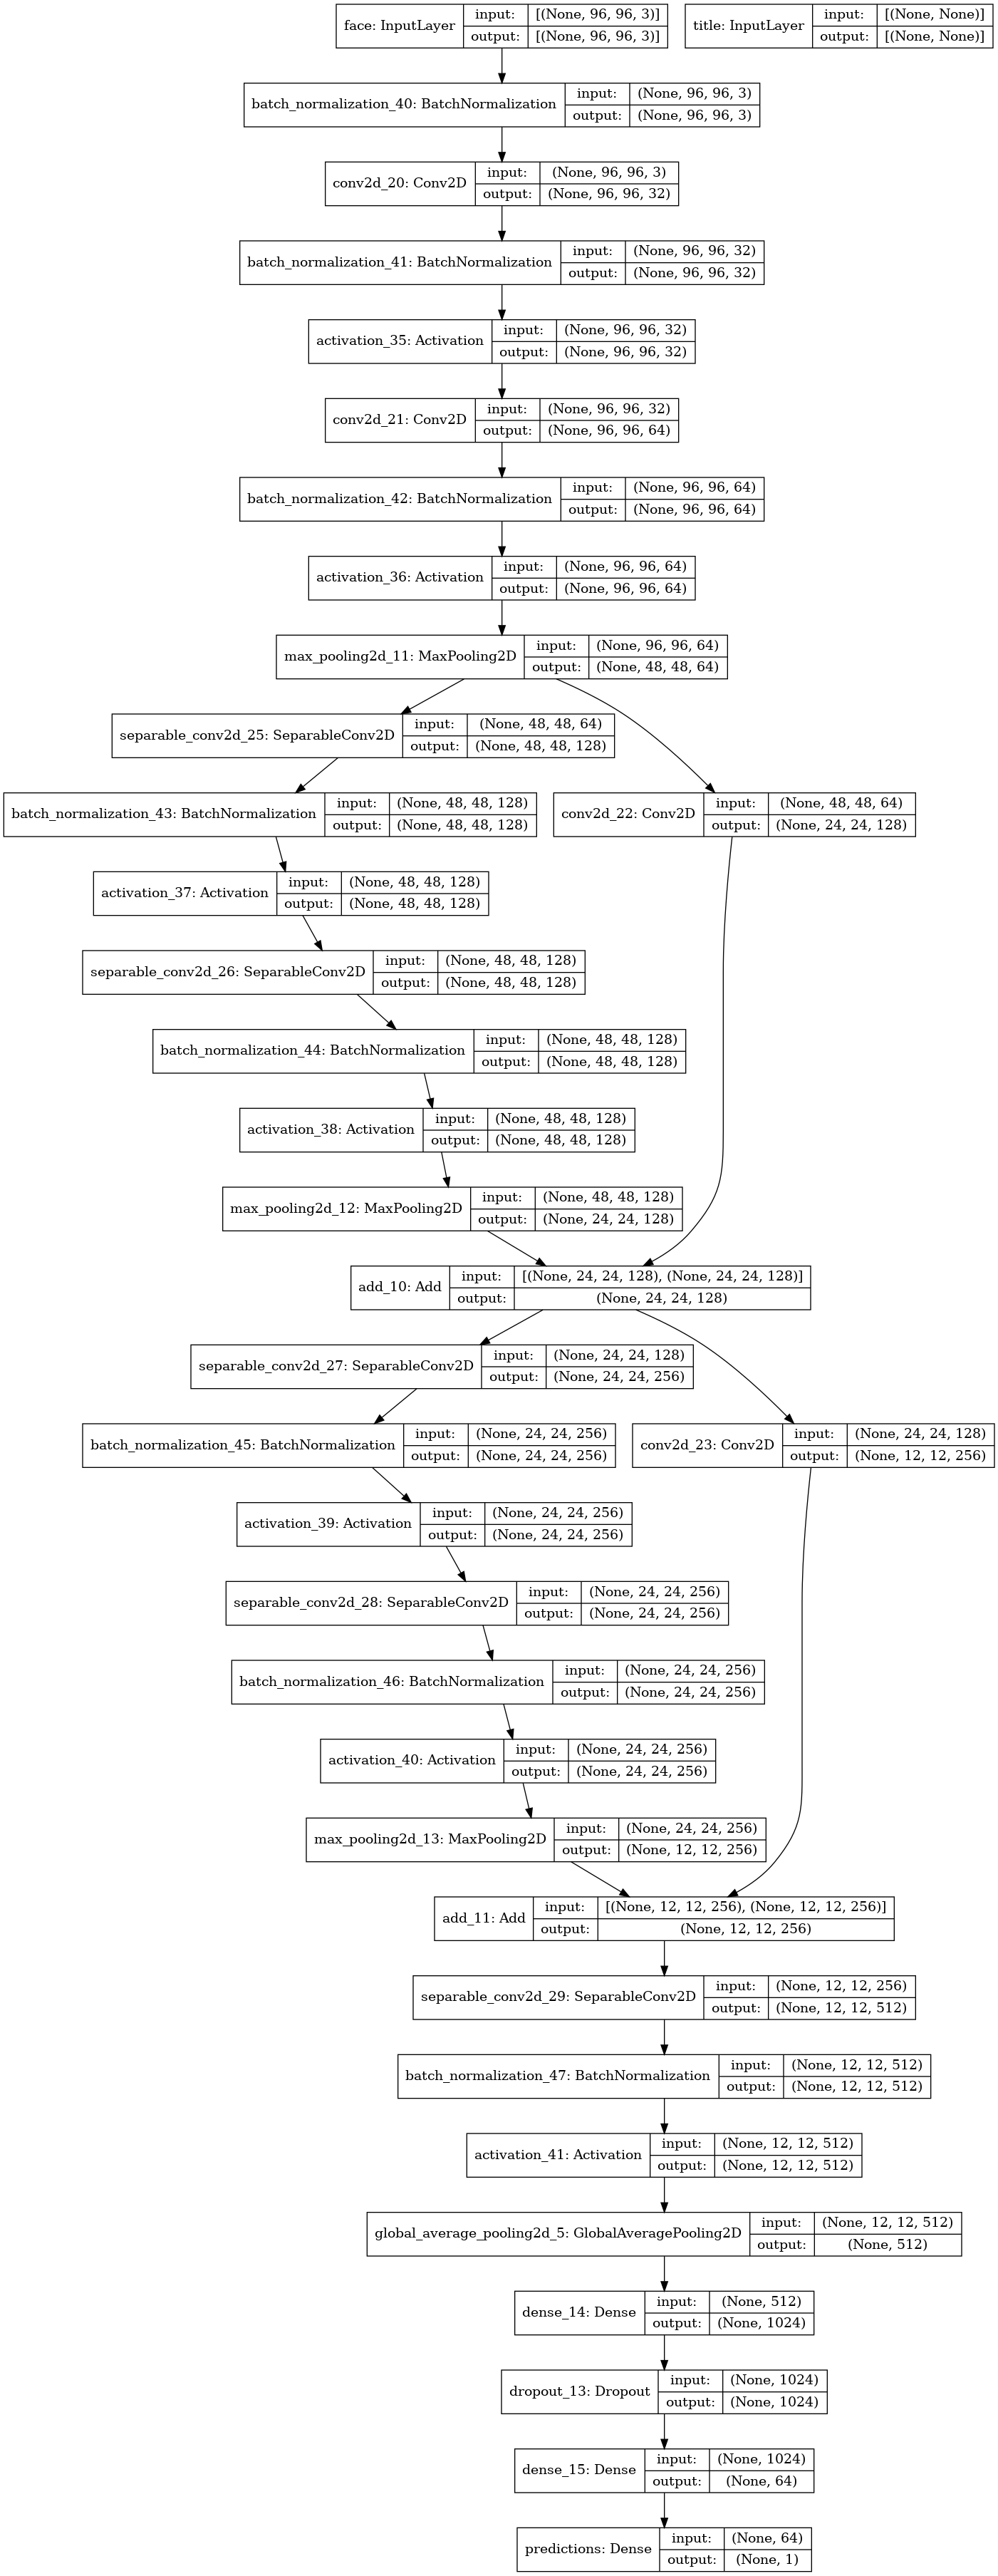

In [60]:
thumbnail_input=keras.Input(shape=(96,96,3),name='face')

#2d conv for thumbnail
x=layers.BatchNormalization()(thumbnail_input)

x=layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.MaxPooling2D(2,strides=2,padding='same')(x)

prev=x

for size in [128, 256]:
    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size,1,strides=2,padding="same")(prev)
    
    x = layers.add([x,residual])  # Add back residual
    prev=x                        # Set aside next residual


x=layers.SeparableConv2D(512,3,padding="same")(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

flat=layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1024, activation="relu")(flat)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
x = layers.Dense(64,activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model([thumbnail_input,inputs], predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [61]:
epochs = 5
model.fit(X_train,y_train, validation_split=0.2, epochs=epochs)

Epoch 1/5


/home/errorgorn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['thumb'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


244/244 [==============================] - 18s 71ms/step - loss: 0.6553 - acc: 0.6480 - precision_m: 0.6137 - recall_m: 0.4147 - f1_m: 0.4785 - val_loss: 0.6829 - val_acc: 0.5524 - val_precision_m: 0.0492 - val_recall_m: 0.0030 - val_f1_m: 0.0057
Epoch 2/5
244/244 [==============================] - 17s 70ms/step - loss: 0.6263 - acc: 0.6722 - precision_m: 0.6699 - recall_m: 0.4818 - f1_m: 0.5517 - val_loss: 0.6467 - val_acc: 0.6381 - val_precision_m: 0.8593 - val_recall_m: 0.2306 - val_f1_m: 0.3511
Epoch 3/5
244/244 [==============================] - 17s 70ms/step - loss: 0.6040 - acc: 0.6941 - precision_m: 0.7333 - recall_m: 0.4833 - f1_m: 0.5724 - val_loss: 0.6390 - val_acc: 0.6448 - val_precision_m: 0.8669 - val_recall_m: 0.2516 - val_f1_m: 0.3779
Epoch 4/5
244/244 [==============================] - 17s 70ms/step - loss: 0.5980 - acc: 0.6983 - precision_m: 0.7433 - recall_m: 0.4700 - f1_m: 0.5635 - val_loss: 0.6055 - val_acc: 0.6915 - val_precision_m: 0.7431 - val_recall_m: 0.4711 -

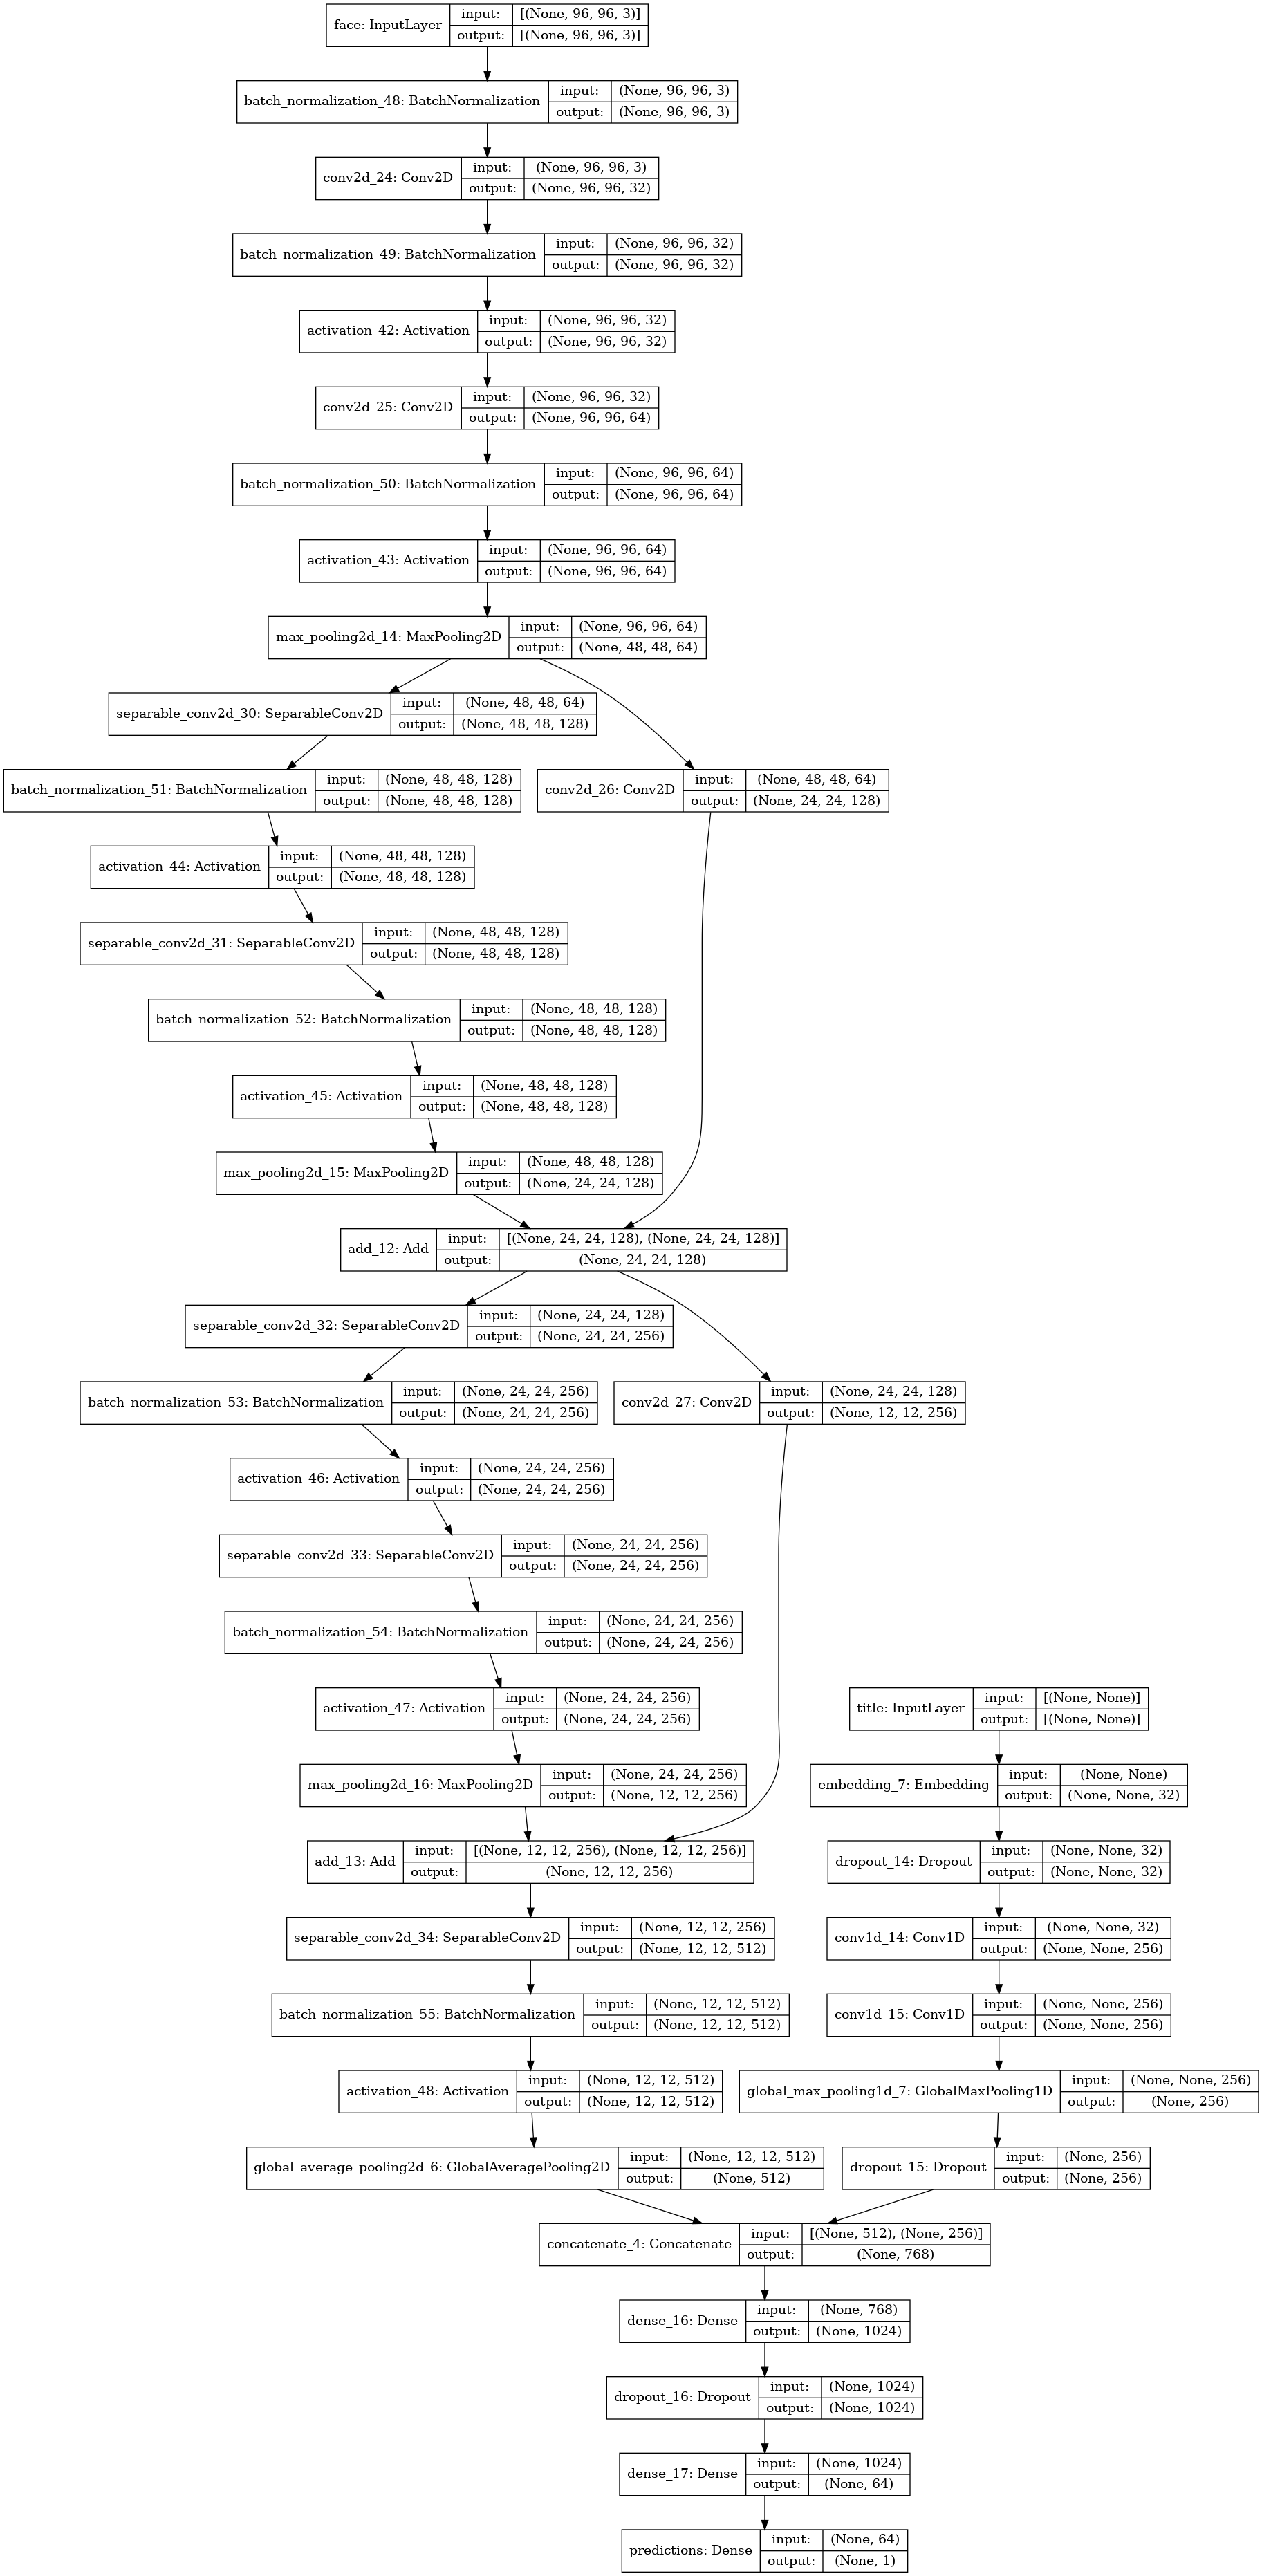

In [62]:
thumbnail_input=keras.Input(shape=(96,96,3),name='face')

#2d conv for thumbnail
x=layers.BatchNormalization()(thumbnail_input)

x=layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

x=layers.MaxPooling2D(2,strides=2,padding='same')(x)

prev=x

for size in [128, 256]:
    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.SeparableConv2D(size,3,padding="same")(x)
    x=layers.BatchNormalization()(x)
    x=layers.Activation("relu")(x)

    x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size,1,strides=2,padding="same")(prev)
    
    x = layers.add([x,residual])  # Add back residual
    prev=x                        # Set aside next residual


x=layers.SeparableConv2D(512,3,padding="same")(x)
x=layers.BatchNormalization()(x)
x=layers.Activation("relu")(x)

flat=layers.GlobalAveragePooling2D()(x)

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64",name="title")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.7)(x)

# Conv1D + global max pooling
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
x = layers.Conv1D(256, 7, padding="valid", activation="relu", strides=2)(x)
flat2 = layers.GlobalMaxPooling1D()(x)

dropout=layers.Dropout(0.75)(flat2)

# We add a vanilla hidden layer:
flat_comb=layers.concatenate([flat,dropout])
x = layers.Dense(1024, activation="relu")(flat_comb)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
x = layers.Dense(64,activation="relu")(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model([thumbnail_input,inputs], predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc", precision_m, recall_m, f1_m])
plot_model(model,show_layer_names=1,show_shapes=True)

In [ ]:
epochs = 10
model.fit(X_train,y_train, validation_split=0.2, epochs=epochs)

Epoch 1/10


/home/errorgorn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['thumb'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


244/244 [==============================] - 21s 80ms/step - loss: 0.6303 - acc: 0.6762 - precision_m: 0.6954 - recall_m: 0.5026 - f1_m: 0.5516 - val_loss: 0.2505 - val_acc: 0.8973 - val_precision_m: 0.9315 - val_recall_m: 0.8322 - val_f1_m: 0.8755
Epoch 2/10
244/244 [==============================] - 19s 79ms/step - loss: 0.2319 - acc: 0.8986 - precision_m: 0.8869 - recall_m: 0.8814 - f1_m: 0.8777 - val_loss: 0.2007 - val_acc: 0.9209 - val_precision_m: 0.9455 - val_recall_m: 0.8719 - val_f1_m: 0.9043
Epoch 3/10
244/244 [==============================] - 19s 80ms/step - loss: 0.1642 - acc: 0.9349 - precision_m: 0.9392 - recall_m: 0.9136 - f1_m: 0.9232 - val_loss: 0.2014 - val_acc: 0.9230 - val_precision_m: 0.9423 - val_recall_m: 0.8809 - val_f1_m: 0.9074
Epoch 4/10
244/244 [==============================] - 20s 81ms/step - loss: 0.1337 - acc: 0.9440 - precision_m: 0.9404 - recall_m: 0.9369 - f1_m: 0.9364 - val_loss: 0.2060 - val_acc: 0.9230 - val_precision_m: 0.9153 - val_recall_m: 0.912